Vérification des valeurs manquantes :
Outlook        0
Temperature    0
Humidity       0
Windy          0
PlayTennis     0
dtype: int64

Variables explicatives après encodage :
   Windy  Outlook_Overcast  Outlook_Rain  Outlook_Sunny  Temperature_Cool  \
0  False             False         False           True             False   
1   True             False         False           True             False   
2  False              True         False          False             False   
3  False             False          True          False             False   
4  False             False          True          False              True   

   Temperature_Hot  Temperature_Mild  Humidity_High  Humidity_Normal  
0             True             False           True            False  
1             True             False           True            False  
2             True             False           True            False  
3            False              True           True            False  
4    

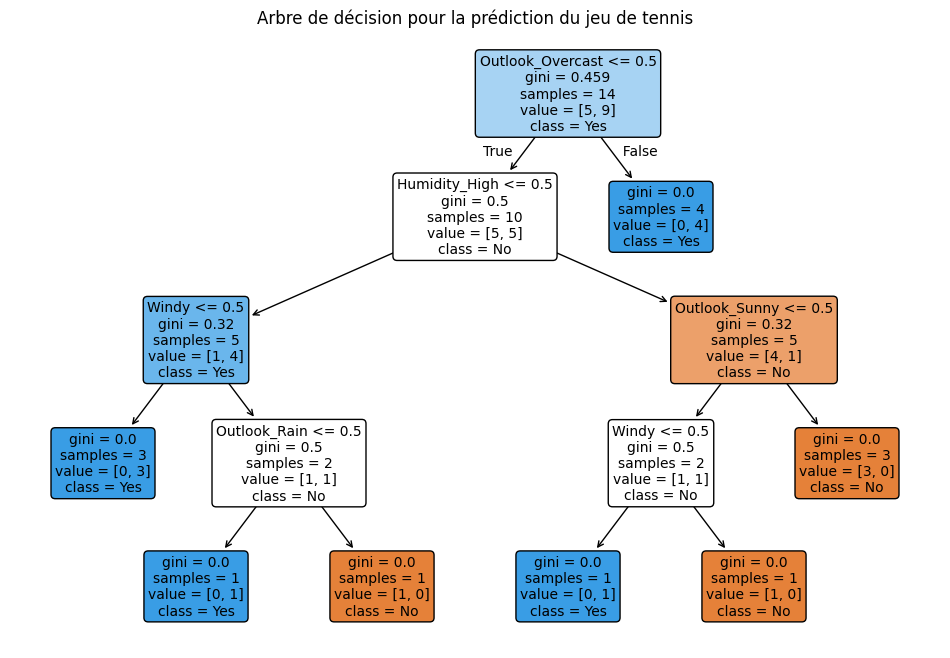

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt


df = pd.read_csv('play_tennis.csv')


print("Vérification des valeurs manquantes :")
print(df.isnull().sum())


X = pd.get_dummies(df.drop('PlayTennis', axis=1), drop_first=False)
print("\nVariables explicatives après encodage :")
print(X.head())

y = df['PlayTennis']
print("\nDistribution de la variable cible :")
print(y.value_counts())


y = y.map({'Yes': 1, 'No': 0})
print("\nVariable cible encodée :")
print(y.value_counts())


clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(X, y)


plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['No', 'Yes'], rounded=True)
plt.title("Arbre de décision pour la prédiction du jeu de tennis")
plt.savefig('arbre_decision_tennis.png')  # Sauvegarder l'image pour visualisation
print("\nL'arbre de décision a été généré et sauvegardé dans 'arbre_decision_tennis.png'")


feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nImportance des variables :")
print(feature_importance)


new_data = pd.DataFrame({
    'Outlook': ['Sunny'],
    'Temperature': ['Hot'],
    'Humidity': ['High'],
    'Windy': [False]
})

print("\nNouvelle observation à prédire :")
print(new_data)


new_data_encoded = pd.get_dummies(new_data, drop_first=False)


missing_cols = set(X.columns) - set(new_data_encoded.columns)
for col in missing_cols:
    new_data_encoded[col] = 0


new_data_encoded = new_data_encoded[X.columns]

print("\nNouvelle observation encodée :")
print(new_data_encoded)

# Faire la prédiction
prediction = clf.predict(new_data_encoded)
probability = clf.predict_proba(new_data_encoded)

print("\nPrédiction :")
print(f"La personne jouera au tennis : {'Oui' if prediction[0] == 1 else 'Non'}")
print(f"Probabilité : Non = {probability[0][0]:.2f}, Oui = {probability[0][1]:.2f}")


def extract_path(tree, feature_names, class_names):
    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold
    
    paths = []
    for node in range(n_nodes):
        if tree.children_left[node] == tree.children_right[node]:  # feuille
            path = ""
            node_id = node
            while node_id != 0:  # tant qu'on n'est pas à la racine
                parent_node = -1
                for i in range(n_nodes):
                    if children_left[i] == node_id or children_right[i] == node_id:
                        parent_node = i
                        break
                
                if parent_node == -1:
                    break
                
                if children_left[parent_node] == node_id:
                    path = f"{feature_names[feature[parent_node]]} <= {threshold[parent_node]:.3f} and " + path
                else:
                    path = f"{feature_names[feature[parent_node]]} > {threshold[parent_node]:.3f} and " + path
                
                node_id = parent_node
            
            if path:
                path = path[:-5]  # enlever le dernier "and "
            
            class_idx = np.argmax(tree.value[node])
            paths.append(f"Si {path}, alors {class_names[class_idx]}")
    
    return paths

rules = extract_path(clf.tree_, X.columns, ['Non', 'Oui'])
print("\nRègles de décision extraites de l'arbre :")
for rule in rules:
    print(rule)